In [1]:
using JuMP

function analyzeData(raw)
    
    N = size(raw)[1] 
    raw = raw[2:N, :]

    raw[:,21] = sum(raw[:,i] for i = 13:20)/8
    raw[:,34] = sum(raw[:,i] for i = 22:33)/12
    raw[:,42] = sum(raw[:,i] for i = 35:41)/7

    GKindex = find(raw[:,6].=="GK")    # Rows containing GK's
    LWindex = find(raw[:,6].=="LW")    # Rows containing LW's
    RWindex = find(raw[:,6].=="RW")    # Rows containing RW's
    STindex = find(raw[:,6].=="ST")    # Rows containing ST's
    CFindex = find(raw[:,6].=="CF")    # Rows containing CF's
    CMindex = find(raw[:,6].=="CM")    # Rows containing CM's
    LMindex = find(raw[:,6].=="LM")    # Rows containing LM's
    RMindex = find(raw[:,6].=="RM")    # Rows containing RM's
    CAMindex = find(raw[:,6].=="CAM")  # Rows containing CAM's
    CDMindex = find(raw[:,6].=="CDM")  # Rows containing CDM's
    CBindex = find(raw[:,6].=="CB")    # Rows containing CB's
    LBindex = find(raw[:,6].=="LB")    # Rows containing LB's
    RBindex = find(raw[:,6].=="RB")    # Rows containing RB's

    for i in [LWindex, RWindex, STindex, CFindex]
        raw[i, 21] = raw[i, 1]
    end

    for i in [CMindex, LMindex, RMindex, CAMindex, CDMindex]
        raw[i, 34] = raw[i, 1]
    end

    for i in [CBindex, LBindex, RBindex, GKindex]
        raw[i, 42] = raw[i, 1]
    end
    
    return raw
end;

In [22]:
using JuMP, Cbc

function attackModel(λ, CBlimit, maxSalary, raw)
    
    N = size(raw)[1]                   # Number of players
    GKindex = find(raw[:,6].=="GK")    # Rows containing GK's
    LWindex = find(raw[:,6].=="LW")    # Rows containing LW's
    RWindex = find(raw[:,6].=="RW")    # Rows containing RW's
    STindex = find(raw[:,6].=="ST")    # Rows containing ST's
    CFindex = find(raw[:,6].=="CF")    # Rows containing CF's
    CMindex = find(raw[:,6].=="CM")    # Rows containing CM's
    LMindex = find(raw[:,6].=="LM")    # Rows containing LM's
    RMindex = find(raw[:,6].=="RM")    # Rows containing RM's
    CAMindex = find(raw[:,6].=="CAM")  # Rows containing CAM's
    CDMindex = find(raw[:,6].=="CDM")  # Rows containing CDM's
    CBindex = find(raw[:,6].=="CB")    # Rows containing CB's
    LBindex = find(raw[:,6].=="LB")    # Rows containing LB's
    RBindex = find(raw[:,6].=="RB")    # Rows containing RB's
    
    clubs = unique(raw[:,7])           # List of unique clubs of the players
    Num = 11                           # Total players in a team
    T = length(clubs)                  # Number of unique clubs
    minLimit = 0                       # Minimum number of player in every position (0)
    minForward = 1                     # Minimum number of forward players(including LW, RW, ST, CF)
    maxForward = 3                     # Maximum number of forward players(including LW, RW, ST, CF)
    minMid = 3                         # Minimum number of midfield players(including CM, CAM, CDM, LM, RM)
    maxMid = 5                         # Maximum number of midfield players(including CM, CAM, CDM, LM, RM)
    minBack = 2                        # Minimum number of back players(including CB, LB, RB)
    maxBack = 4                        # Maximum number of back players(including CB, LB, RB)
    
    # Maximum number of player in every position
    GKlimit = LWlimit = RWlimit = STlimit = CFlimit = CMlimit = CAMlimit = 1  
    CDMlimit = LMlimit = RMlimit = CAMlimit =  LBlimit = RBlimit = 1
    CBlimit = 2
    
    m = Model(solver=CbcSolver())
    
    @variable(m, k[1:N], Bin)             # Indicator variable:  1- Player on team, 0- Player not on team
    @constraint(m, sum{k[i]*raw[i,2], i=1:N} <= maxSalary)           # Salary cap constraint
    @constraint(m, sum{k[i], i = GKindex} == GKlimit)                # Number of GK's constraint
    @constraint(m, minLimit <= sum{k[i], i = LWindex} <= LWlimit)    # Number of LW's constraint
    @constraint(m, minLimit <= sum{k[i], i = RWindex} <= RWlimit)    # Number of RW's constraint
    @constraint(m, minLimit <= sum{k[i], i = STindex} <= STlimit)    # Number of ST's constraint
    @constraint(m, minLimit <= sum{k[i], i = CFindex} <= CFlimit)    # Number of CF's constraint
    @constraint(m, minLimit <= sum{k[i], i = CMindex} <= CMlimit)    # Number of CM's constraint
    @constraint(m, minLimit <= sum{k[i], i = LMindex} <= LMlimit)    # Number of LM's constraint
    @constraint(m, minLimit <= sum{k[i], i = RMindex} <= RMlimit)    # Number of RM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CAMindex} <= CAMlimit)  # Number of CAM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CDMindex} <= CDMlimit)  # Number of CDM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CBindex} <= CBlimit)    # Number of CB's constraint
    @constraint(m, minLimit <= sum{k[i], i = LBindex} <= LBlimit)    # Number of LB's constraint
    @constraint(m, minLimit <= sum{k[i], i = RBindex} <= RBlimit)    # Number of RB's constraint
    
    # Number of players(forward, midfield and back)constraint
    @constraint(m, minForward <= sum{k[i], i = [LWindex; RWindex; STindex; CFindex]} <= maxForward)
    @constraint(m, minMid <= sum{k[i], i = [CMindex; LMindex; RMindex; CAMindex; CDMindex]} <= maxMid)
    @constraint(m, minBack <= sum{k[i], i = [CBindex; LBindex; RBindex]} <= maxBack)
    
    # Total number of players must be Num (11)
    @constraint(m, sum{k[i], i = [GKindex; LWindex; RWindex; STindex; CFindex; CMindex; LMindex; RMindex; CAMindex; CDMindex; 
                                                CBindex; LBindex; RBindex]} == 11)
    
    # Limit amount of players from one particular team

    
    # Maximize the overall ability according to the value of λ
    @objective(m, Max, λ*sum{k[i]*raw[i,21], i=1:N} + (1-λ)/2*(sum{k[i]*raw[i,34], i=1:N} + sum{k[i]*raw[i,42], i=1:N}))
    
    solve(m);
    
    Ra = getvalue(sum(k.*raw[:,21]/Num))  # Average attack ability
    Rm = getvalue(sum(k.*raw[:,34]/Num))  # Average midfield ability
    Rd = getvalue(sum(k.*raw[:,42]/Num))  # Average defensive ability
    R = getvalue(sum(k.*raw[:,1]/Num))    # Average overall ability
    Ip = getvalue(k)                    # Indicator player vector
    
    return(R, Ra, Rm, Rd, Ip)
end;

In [23]:
using JuMP, Cbc

function midfieldModel(λ, CBlimit, maxSalary, raw)
    
    N = size(raw)[1]                   # Number of players
    GKindex = find(raw[:,6].=="GK")    # Rows containing GK's
    LWindex = find(raw[:,6].=="LW")    # Rows containing LW's
    RWindex = find(raw[:,6].=="RW")    # Rows containing RW's
    STindex = find(raw[:,6].=="ST")    # Rows containing ST's
    CFindex = find(raw[:,6].=="CF")    # Rows containing CF's
    CMindex = find(raw[:,6].=="CM")    # Rows containing CM's
    LMindex = find(raw[:,6].=="LM")    # Rows containing LM's
    RMindex = find(raw[:,6].=="RM")    # Rows containing RM's
    CAMindex = find(raw[:,6].=="CAM")  # Rows containing CAM's
    CDMindex = find(raw[:,6].=="CDM")  # Rows containing CDM's
    CBindex = find(raw[:,6].=="CB")    # Rows containing CB's
    LBindex = find(raw[:,6].=="LB")    # Rows containing LB's
    RBindex = find(raw[:,6].=="RB")    # Rows containing RB's
    
    clubs = unique(raw[:,7])           # List of unique clubs of the players
    Num = 11                           # Total players in a team
    T = length(clubs)                  # Number of unique clubs
    minLimit = 0                       # Minimum number of player in every position (0)
    minForward = 1                     # Minimum number of forward players(including LW, RW, ST, CF)
    maxForward = 3                     # Maximum number of forward players(including LW, RW, ST, CF)
    minMid = 3                         # Minimum number of midfield players(including CM, CAM, CDM, LM, RM)
    maxMid = 5                         # Maximum number of midfield players(including CM, CAM, CDM, LM, RM)
    minBack = 2                        # Minimum number of back players(including CB, LB, RB)
    maxBack = 4                        # Maximum number of back players(including CB, LB, RB)
    
    # Maximum number of player in every position
    GKlimit = LWlimit = RWlimit = STlimit = CFlimit = CMlimit = CAMlimit = 1  
    CDMlimit = LMlimit = RMlimit = CAMlimit =  LBlimit = RBlimit = 1
    CBlimit = 2
    
    m = Model(solver=CbcSolver())
    
    @variable(m, k[1:N], Bin)             # Indicator variable:  1- Player on team, 0- Player not on team
    @constraint(m, sum{k[i]*raw[i,2], i=1:N} <= maxSalary)           # Salary cap constraint
    @constraint(m, sum{k[i], i = GKindex} == GKlimit)                # Number of GK's constraint
    @constraint(m, minLimit <= sum{k[i], i = LWindex} <= LWlimit)    # Number of LW's constraint
    @constraint(m, minLimit <= sum{k[i], i = RWindex} <= RWlimit)    # Number of RW's constraint
    @constraint(m, minLimit <= sum{k[i], i = STindex} <= STlimit)    # Number of ST's constraint
    @constraint(m, minLimit <= sum{k[i], i = CFindex} <= CFlimit)    # Number of CF's constraint
    @constraint(m, minLimit <= sum{k[i], i = CMindex} <= CMlimit)    # Number of CM's constraint
    @constraint(m, minLimit <= sum{k[i], i = LMindex} <= LMlimit)    # Number of LM's constraint
    @constraint(m, minLimit <= sum{k[i], i = RMindex} <= RMlimit)    # Number of RM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CAMindex} <= CAMlimit)  # Number of CAM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CDMindex} <= CDMlimit)  # Number of CDM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CBindex} <= CBlimit)    # Number of CB's constraint
    @constraint(m, minLimit <= sum{k[i], i = LBindex} <= LBlimit)    # Number of LB's constraint
    @constraint(m, minLimit <= sum{k[i], i = RBindex} <= RBlimit)    # Number of RB's constraint
    
    # Number of players(forward, midfield and back)constraint
    @constraint(m, minForward <= sum{k[i], i = [LWindex; RWindex; STindex; CFindex]} <= maxForward)
    @constraint(m, minMid <= sum{k[i], i = [CMindex; LMindex; RMindex; CAMindex; CDMindex]} <= maxMid)
    @constraint(m, minBack <= sum{k[i], i = [CBindex; LBindex; RBindex]} <= maxBack)
    
    # Total number of players must be Num (11)
    @constraint(m, sum{k[i], i = [GKindex; LWindex; RWindex; STindex; CFindex; CMindex; LMindex; RMindex; CAMindex; CDMindex; 
                                                CBindex; LBindex; RBindex]} == Num)
    
    # Limit amount of players from one particular team
    for t = 1:T
        clubIndex = find(raw[:,7].==clubs[t])
        @constraint(m, sum{k[i], i = clubIndex} <= CBlimit)
    end
    
    # Maximize the overall ability according to the value of λ
    @objective(m, Max, λ*sum{k[i]*raw[i,34], i=1:N} + (1-λ)/2*(sum{k[i]*raw[i,21], i=1:N} + sum{k[i]*raw[i,42], i=1:N}))
    
    solve(m);
    
    Ra = getvalue(sum(k.*raw[:,21]/Num))  # Average attack ability
    Rm = getvalue(sum(k.*raw[:,34]/Num))  # Average midfield ability
    Rd = getvalue(sum(k.*raw[:,42]/Num))  # Average defensive ability
    R = getvalue(sum(k.*raw[:,1]/Num))    # Average overall ability
    Ip = getvalue(k)                    # Indicator player vector
    
    return(R, Ra, Rm, Rd, Ip)
end;

In [28]:
using JuMP, Cbc

function defendModel(λ, CBlimit, maxSalary, raw)
    
    N = size(raw)[1]                   # Number of players
    GKindex = find(raw[:,6].=="GK")    # Rows containing GK's
    LWindex = find(raw[:,6].=="LW")    # Rows containing LW's
    RWindex = find(raw[:,6].=="RW")    # Rows containing RW's
    STindex = find(raw[:,6].=="ST")    # Rows containing ST's
    CFindex = find(raw[:,6].=="CF")    # Rows containing CF's
    CMindex = find(raw[:,6].=="CM")    # Rows containing CM's
    LMindex = find(raw[:,6].=="LM")    # Rows containing LM's
    RMindex = find(raw[:,6].=="RM")    # Rows containing RM's
    CAMindex = find(raw[:,6].=="CAM")  # Rows containing CAM's
    CDMindex = find(raw[:,6].=="CDM")  # Rows containing CDM's
    CBindex = find(raw[:,6].=="CB")    # Rows containing CB's
    LBindex = find(raw[:,6].=="LB")    # Rows containing LB's
    RBindex = find(raw[:,6].=="RB")    # Rows containing RB's
    
    clubs = unique(raw[:,7])           # List of unique clubs of the players
    Num = 11                           # Total players in a team
    T = length(clubs)                  # Number of unique clubs
    minLimit = 0                       # Minimum number of player in every position (0)
    minForward = 1                     # Minimum number of forward players(including LW, RW, ST, CF)
    maxForward = 3                     # Maximum number of forward players(including LW, RW, ST, CF)
    minMid = 3                         # Minimum number of midfield players(including CM, CAM, CDM, LM, RM)
    maxMid = 5                         # Maximum number of midfield players(including CM, CAM, CDM, LM, RM)
    minBack = 2                        # Minimum number of back players(including CB, LB, RB)
    maxBack = 4                        # Maximum number of back players(including CB, LB, RB)
    
    # Maximum number of player in every position
    GKlimit = LWlimit = RWlimit = STlimit = CFlimit = CMlimit = CAMlimit = 1  
    CDMlimit = LMlimit = RMlimit = CAMlimit =  LBlimit = RBlimit = 1
    CBlimit = 2
    
    m = Model(solver=CbcSolver())
    
    @variable(m, k[1:N], Bin)             # Indicator variable:  1- Player on team, 0- Player not on team
    @constraint(m, sum{k[i]*raw[i,2], i=1:N} <= maxSalary)           # Salary cap constraint
    @constraint(m, sum{k[i], i = GKindex} == GKlimit)                # Number of GK's constraint
    @constraint(m, minLimit <= sum{k[i], i = LWindex} <= LWlimit)    # Number of LW's constraint
    @constraint(m, minLimit <= sum{k[i], i = RWindex} <= RWlimit)    # Number of RW's constraint
    @constraint(m, minLimit <= sum{k[i], i = STindex} <= STlimit)    # Number of ST's constraint
    @constraint(m, minLimit <= sum{k[i], i = CFindex} <= CFlimit)    # Number of CF's constraint
    @constraint(m, minLimit <= sum{k[i], i = CMindex} <= CMlimit)    # Number of CM's constraint
    @constraint(m, minLimit <= sum{k[i], i = LMindex} <= LMlimit)    # Number of LM's constraint
    @constraint(m, minLimit <= sum{k[i], i = RMindex} <= RMlimit)    # Number of RM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CAMindex} <= CAMlimit)  # Number of CAM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CDMindex} <= CDMlimit)  # Number of CDM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CBindex} <= CBlimit)    # Number of CB's constraint
    @constraint(m, minLimit <= sum{k[i], i = LBindex} <= LBlimit)    # Number of LB's constraint
    @constraint(m, minLimit <= sum{k[i], i = RBindex} <= RBlimit)    # Number of RB's constraint
    
    # Number of players(forward, midfield and back)constraint
    @constraint(m, minForward <= sum{k[i], i = [LWindex; RWindex; STindex; CFindex]} <= maxForward)
    @constraint(m, minMid <= sum{k[i], i = [CMindex; LMindex; RMindex; CAMindex; CDMindex]} <= maxMid)
    @constraint(m, minBack <= sum{k[i], i = [CBindex; LBindex; RBindex]} <= maxBack)
    
    # Total number of players must be Num (11)
    @constraint(m, sum{k[i], i = [GKindex; LWindex; RWindex; STindex; CFindex; CMindex; LMindex; RMindex; CAMindex; CDMindex; 
                                                CBindex; LBindex; RBindex]} == Num)
    
    # Limit amount of players from one particular team

    
    # Maximize the overall ability according to the value of λ
    @objective(m, Max, λ*sum{k[i]*raw[i,42], i=1:N} + (1-λ)/2*(sum{k[i]*raw[i,21], i=1:N} + sum{k[i]*raw[i,34], i=1:N}))
    
    solve(m);
    
    Ra = getvalue(sum(k.*raw[:,21]/Num))  # Average attack ability
    Rm = getvalue(sum(k.*raw[:,34]/Num))  # Average midfield ability
    Rd = getvalue(sum(k.*raw[:,42]/Num))  # Average defensive ability
    R = getvalue(sum(k.*raw[:,1]/Num))    # Average overall ability
    Ip = getvalue(k)                    # Indicator player vector
    
    return(R, Ra, Rm, Rd, Ip)
end;

In [29]:
using JuMP, Cbc

function rateModel(CBlimit, maxSalary, raw)
    
    N = size(raw)[1]                   # Number of players
    GKindex = find(raw[:,6].=="GK")    # Rows containing GK's
    LWindex = find(raw[:,6].=="LW")    # Rows containing LW's
    RWindex = find(raw[:,6].=="RW")    # Rows containing RW's
    STindex = find(raw[:,6].=="ST")    # Rows containing ST's
    CFindex = find(raw[:,6].=="CF")    # Rows containing CF's
    CMindex = find(raw[:,6].=="CM")    # Rows containing CM's
    LMindex = find(raw[:,6].=="LM")    # Rows containing LM's
    RMindex = find(raw[:,6].=="RM")    # Rows containing RM's
    CAMindex = find(raw[:,6].=="CAM")  # Rows containing CAM's
    CDMindex = find(raw[:,6].=="CDM")  # Rows containing CDM's
    CBindex = find(raw[:,6].=="CB")    # Rows containing CB's
    LBindex = find(raw[:,6].=="LB")    # Rows containing LB's
    RBindex = find(raw[:,6].=="RB")    # Rows containing RB's
    
    clubs = unique(raw[:,7])           # List of unique clubs of the players
    Num = 11                           # Total players in a team
    T = length(clubs)                  # Number of unique clubs
    minLimit = 0                       # Minimum number of player in every position (0)
    minForward = 1                     # Minimum number of forward players(including LW, RW, ST, CF)
    maxForward = 3                     # Maximum number of forward players(including LW, RW, ST, CF)
    minMid = 3                         # Minimum number of midfield players(including CM, CAM, CDM, LM, RM)
    maxMid = 5                         # Maximum number of midfield players(including CM, CAM, CDM, LM, RM)
    minBack = 2                        # Minimum number of back players(including CB, LB, RB)
    maxBack = 4                        # Maximum number of back players(including CB, LB, RB)
    
    # Maximum number of player in every position
    GKlimit = LWlimit = RWlimit = STlimit = CFlimit = CMlimit = CAMlimit = 1  
    CDMlimit = LMlimit = RMlimit = CAMlimit =  LBlimit = RBlimit = 1
    CBlimit = 2
    
    m = Model(solver=CbcSolver())
    
    @variable(m, k[1:N], Bin)             # Indicator variable:  1- Player on team, 0- Player not on team
    @constraint(m, sum{k[i]*raw[i,2], i=1:N} <= maxSalary)           # Salary cap constraint
    @constraint(m, sum{k[i], i = GKindex} == GKlimit)                # Number of GK's constraint
    @constraint(m, minLimit <= sum{k[i], i = LWindex} <= LWlimit)    # Number of LW's constraint
    @constraint(m, minLimit <= sum{k[i], i = RWindex} <= RWlimit)    # Number of RW's constraint
    @constraint(m, minLimit <= sum{k[i], i = STindex} <= STlimit)    # Number of ST's constraint
    @constraint(m, minLimit <= sum{k[i], i = CFindex} <= CFlimit)    # Number of CF's constraint
    @constraint(m, minLimit <= sum{k[i], i = CMindex} <= CMlimit)    # Number of CM's constraint
    @constraint(m, minLimit <= sum{k[i], i = LMindex} <= LMlimit)    # Number of LM's constraint
    @constraint(m, minLimit <= sum{k[i], i = RMindex} <= RMlimit)    # Number of RM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CAMindex} <= CAMlimit)  # Number of CAM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CDMindex} <= CDMlimit)  # Number of CDM's constraint
    @constraint(m, minLimit <= sum{k[i], i = CBindex} <= CBlimit)    # Number of CB's constraint
    @constraint(m, minLimit <= sum{k[i], i = LBindex} <= LBlimit)    # Number of LB's constraint
    @constraint(m, minLimit <= sum{k[i], i = RBindex} <= RBlimit)    # Number of RB's constraint
    
    # Number of players(forward, midfield and back)constraint
    @constraint(m, minForward <= sum{k[i], i = [LWindex; RWindex; STindex; CFindex]} <= maxForward)
    @constraint(m, minMid <= sum{k[i], i = [CMindex; LMindex; RMindex; CAMindex; CDMindex]} <= maxMid)
    @constraint(m, minBack <= sum{k[i], i = [CBindex; LBindex; RBindex]} <= maxBack)
    
     # Limit amount of players from one particular team
    for t = 1:T
        clubIndex = find(raw[:,7].==clubs[t])
        @constraint(m, sum{k[i], i = clubIndex} <= CBlimit)
    end
    
    # Total number of players must be Num (11)
    @constraint(m, sum{k[i], i = [GKindex; LWindex; RWindex; STindex; CFindex; CMindex; LMindex; RMindex; CAMindex; CDMindex; 
                                                CBindex; LBindex; RBindex]} == 11)
    
    # Maximize the overall ability according to the value of λ
    @objective(m, Max, sum{k[i]*raw[i,1], i=1:N})
    
    solve(m);
    
    Ra = getvalue(sum(k.*raw[:,21]/Num))  # Average attack ability
    Rm = getvalue(sum(k.*raw[:,34]/Num))  # Average midfield ability
    Rd = getvalue(sum(k.*raw[:,42]/Num))  # Average defensive ability
    R = getvalue(sum(k.*raw[:,1]/Num))    # Average overall ability
    Ip = getvalue(k)                    # Indicator player vector

    return(R, Ra, Rm, Rd, Ip)
end;

In [30]:
using JuMP,DataFrames

data = "CS524-FinalProjectDatabase.csv"

raw = readcsv(data);

# Analyze data from csv file
raw = analyzeData(raw)

# Application variable
λ = 0.6;

# Max amount of players from the same team
CBlimit = 30;

# Salary cap for the week
maxSalary = 80;


In [31]:
using JuMP, DataFrames

Num = 11        # Total players in a team

# Run attack model
(R, Ra, Rm, Rd, xopt) = attackModel(λ, CBlimit, maxSalary, raw)

# Initialize data frame containing solution
sol = DataFrame(Player = String[], Position = String[], Club = String[], 
                Nation = String[], Age = Int64[], Salary = Float64[], 
                Attack = Float64[], Midfield = Float64[], Defence = Float64[], Rating = Float64[])

for i = 1:length(xopt)
    if xopt[i] == 1
        # Add to dataframe if player is selected
        push!(sol, [raw[i,4] raw[i,6] raw[i,7] raw[i,9] raw[i,10] raw[i,2] raw[i,21] raw[i,34] raw[i,42] raw[i,1]])   
    end
end

println("Total amounts of investment used (in million): ", sum(sol[:,6]))

# Add total row
 push!(sol, ["Average", "/", "/", "/", round(sum(sol[:,5])/Num), sum(sol[:,6])/Num, Ra, 
                    Rm, Rd, sum(sol[:,10])/Num])

# Display optimal team table
sol

Total amounts of investment used (in million): 79.421


,Player,Position,Club,Nation,Age,Salary,Attack,Midfield,Defence,Rating
1,Kevin,GK,Paris Saint-Germain,Germany,25,4.12,66.625,25.25,84.0,84.0
2,Neymar,LW,FC Barcelona,Brazil,24,11.256,91.0,76.0833,86.8571,91.0
3,George,RW,Legends,Northern Ireland,69,10.356,90.0,82.8333,74.8571,90.0
4,Robbie,ST,Legends,England,40,3.125,86.0,75.0,65.4286,86.0
5,Arturo,CM,FC Bayern Munich,Chile,28,6.121,80.375,86.0,84.7143,86.0
6,Stefan,CAM,Legends,Germany,47,5.356,80.75,86.0,81.2857,86.0
7,Lothar,CDM,Legends,Germany,54,11.354,86.5,91.0,83.8571,91.0
8,Ronaldo,CB,VfL Wolfsburg,Brazil,33,5.328,77.0,65.1667,86.0,86.0
9,Marcelo,RB,Real Madrid CF,Brazil,27,8.231,85.875,84.6667,89.0,89.0
10,Adriano,LB,FC Barcelona,Brazil,31,6.32,79.625,76.4167,79.0,79.0


In [32]:
using JuMP, DataFrames

Num = 11        # Total players in a team

# Run midfield model
(R, Ra, Rm, Rd, xopt) = midfieldModel(λ, CBlimit, maxSalary, raw)

# Initialize data frame containing solution
sol = DataFrame(Player = String[], Position = String[], Club = String[], 
                Nation = String[], Age = Int64[], Salary = Float64[], 
                Attack = Float64[], Midfield = Float64[], Defence = Float64[], Rating = Float64[])

for i = 1:length(xopt)
    if xopt[i] == 1
        # Add to dataframe if player is selected
        push!(sol, [raw[i,4] raw[i,6] raw[i,7] raw[i,9] raw[i,10] raw[i,2] raw[i,21] raw[i,34] raw[i,42] raw[i,1]])   
    end
end

println("Total amounts of investment used (in million): ", sum(sol[:,6]))

# Add total row
 push!(sol, ["Average", "/", "/", "/", round(sum(sol[:,5])/Num), sum(sol[:,6])/Num, sum(sol[:,7])/Num, 
                    sum(sol[:,8])/Num, sum(sol[:,9])/Num, sum(sol[:,10])/Num])

# Display optimal team table
sol

Total amounts of investment used (in million): 79.491


,Player,Position,Club,Nation,Age,Salary,Attack,Midfield,Defence,Rating
1,Manuel,GK,FC Bayern Munich,Germany,29,13.654,65.625,46.0,90.0,90.0
2,Nicola,LW,Sassuolo,Italy,24,2.144,75.0,91.75,61.4286,75.0
3,George,RW,Legends,Northern Ireland,69,10.356,90.0,82.8333,74.8571,90.0
4,Wayne,ST,Manchester United,England,30,6.147,87.0,81.9167,70.5714,87.0
5,Arturo,CM,FC Bayern Munich,Chile,28,6.121,80.375,86.0,84.7143,86.0
6,Stefan,CAM,Legends,Germany,47,5.356,80.75,86.0,81.2857,86.0
7,Nemanja,CDM,Chelsea,Serbia,27,5.654,72.875,84.0,83.8571,84.0
8,Diego,CB,Atl??tico Madrid,Uruguay,29,7.654,71.5,72.9167,89.0,89.0
9,Marcelo,RB,Real Madrid CF,Brazil,27,8.231,85.875,84.6667,89.0,89.0
10,Adriano,LB,FC Barcelona,Brazil,31,6.32,79.625,76.4167,79.0,79.0


In [33]:
using JuMP, DataFrames

Num = 11        # Total players in a team

# Run defend model
(R, Ra, Rm, Rd, xopt) = defendModel(λ, CBlimit, maxSalary, raw)

# Initialize data frame containing solution
sol = DataFrame(Player = String[], Position = String[], Club = String[], 
                Nation = String[], Age = Int64[], Salary = Float64[], 
                Attack = Float64[], Midfield = Float64[], Defence = Float64[], Rating = Float64[])

for i = 1:length(xopt)
    if xopt[i] == 1
        # Add to dataframe if player is selected
        push!(sol, [raw[i,4] raw[i,6] raw[i,7] raw[i,9] raw[i,10] raw[i,2] raw[i,21] raw[i,34] raw[i,42] raw[i,1]])   
    end
end

println("Total amounts of investment used (in million): ", sum(sol[:,6]))

# Add total row
 push!(sol, ["Average", "/", "/", "/", round(sum(sol[:,5])/Num), sum(sol[:,6])/Num, sum(sol[:,7])/Num, 
                    sum(sol[:,8])/Num, sum(sol[:,9])/Num, sum(sol[:,10])/Num])

# Display optimal team table
sol

Total amounts of investment used (in million): 79.619


,Player,Position,Club,Nation,Age,Salary,Attack,Midfield,Defence,Rating
1,Jens,GK,Legends,Germany,46,8.487,66.25,38.25,88.0,88.0
2,Neymar,LW,FC Barcelona,Brazil,24,11.256,91.0,76.0833,86.8571,91.0
3,Wayne,ST,Manchester United,England,30,6.147,87.0,81.9167,70.5714,87.0
4,Patrick,CM,Legends,France,39,7.985,79.375,88.0,87.1429,88.0
5,Stefan,CAM,Legends,Germany,47,5.356,80.75,86.0,81.2857,86.0
6,Nemanja,CDM,Chelsea,Serbia,27,5.654,72.875,84.0,83.8571,84.0
7,Franz,CB,Legends,Germany,70,12.523,80.0,79.9167,93.0,93.0
8,Ronaldo,CB,VfL Wolfsburg,Brazil,33,5.328,77.0,65.1667,86.0,86.0
9,Marcelo,RB,Real Madrid CF,Brazil,27,8.231,85.875,84.6667,89.0,89.0
10,Adriano,LB,FC Barcelona,Brazil,31,6.32,79.625,76.4167,79.0,79.0


In [20]:
using JuMP, DataFrames

Num = 11        # Total players in a team

# Run rate model
(R, Ra, Rm, Rd, xopt) = rateModel(CBlimit, maxSalary, raw)

# Initialize data frame containing solution
sol = DataFrame(Player = String[], Position = String[], Club = String[], 
                Nation = String[], Age = Int64[], Salary = Float64[], 
                Attack = Float64[], Midfield = Float64[], Defence = Float64[], Rating = Float64[])

for i = 1:length(xopt)
    if xopt[i] == 1
        # Add to dataframe if player is selected
        push!(sol, [raw[i,4] raw[i,6] raw[i,7] raw[i,9] raw[i,10] raw[i,2] raw[i,21] raw[i,34] raw[i,42] raw[i,1]])   
    end
end

println("Total amounts of investment used (in million): ", sum(sol[:,6]))

# Add total row
 push!(sol, ["Average", "/", "/", "/", round(sum(sol[:,5])/Num), sum(sol[:,6])/Num, sum(sol[:,7])/Num, 
                    sum(sol[:,8])/Num, sum(sol[:,9])/Num, sum(sol[:,10])/Num])

# Display optimal team table
sol

Total amounts of investment used (in million): 79.252


,Player,Position,Club,Nation,Age,Salary,Attack,Midfield,Defence,Rating
1,St??phane,GK,AS Saint-??tienne,France,29,3.586,60.0,24.6667,84.0,84.0
2,C. Ronaldo,LW,Real Madrid CF,Portugal,31,14.654,96.0,81.0,56.2857,96.0
3,Robbie,ST,Legends,England,40,3.125,86.0,75.0,65.4286,86.0
4,Kevin,CM,Manchester City,Belgium,24,6.322,82.75,87.0,62.0,87.0
5,Dennis,CF,Legends,Holland,46,10.025,90.0,77.3333,53.8571,90.0
6,Kevin,CAM,Manchester City,Belgium,24,7.012,83.25,88.0,62.5714,88.0
7,Sergio,CDM,FC Barcelona,Spain,27,6.354,61.375,86.0,79.7143,86.0
8,J??r??me,CB,FC Bayern Munich,Germany,27,5.958,71.75,65.5,87.0,87.0
9,Ronaldo,CB,VfL Wolfsburg,Brazil,33,5.328,77.0,65.1667,86.0,86.0
10,Marcelo,RB,Real Madrid CF,Brazil,27,8.231,85.875,84.6667,89.0,89.0


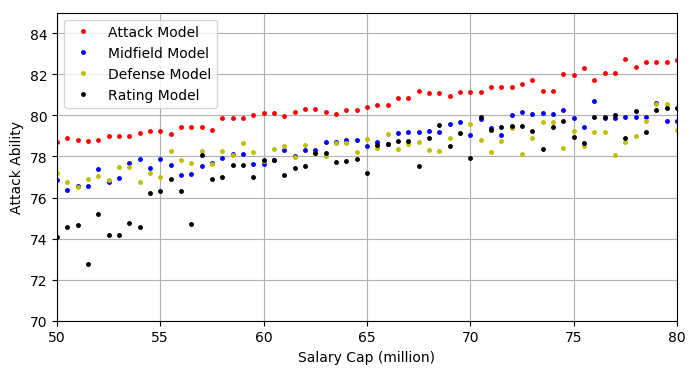

C:\Users\Takashi Matsuzawa\JuliaPro-0.6.4.1\Python\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PyObject <matplotlib.legend.Legend object at 0x0000000034F71C18>

In [21]:
using JuMP, DataFrames, PyPlot

Num = 11        # Total players in a team

figure(figsize=(8,4))
for maxSalary = 50:0.5:80
    (R1, Ra1, Rm1, Rd1, xopt1) = attackModel(λ, CBlimit, maxSalary, raw)
    (R2, Ra2, Rm2, Rd2, xopt2) = midfieldModel(λ, CBlimit, maxSalary, raw)
    (R3, Ra3, Rm3, Rd3, xopt3) = defendModel(λ, CBlimit, maxSalary, raw)
    (R4, Ra4, Rm4, Rd4, xopt4) = rateModel(CBlimit, maxSalary, raw)
    plot(maxSalary, Ra1,"r.", markersize=5)
    plot(maxSalary, Ra2,"b.", markersize=5)
    plot(maxSalary, Ra3,"y.", markersize=5)
    plot(maxSalary, Ra4,"k.", markersize=5)
end
axis([50,80,70,85])
grid("on")
ylabel("Attack Ability")
xlabel("Salary Cap (million)")
legend(["Attack Model", "Midfield Model", "Defense Model", "Rating Model"])

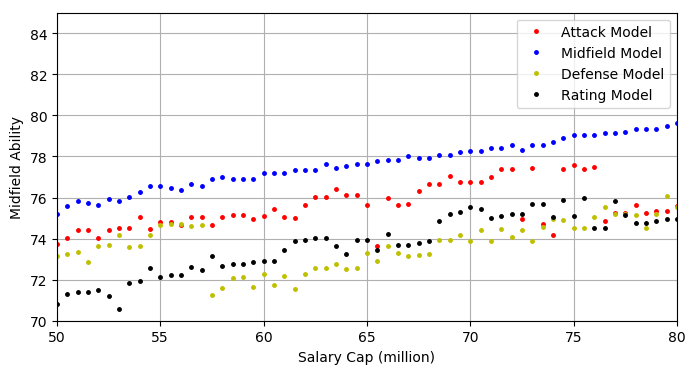

PyObject <matplotlib.legend.Legend object at 0x000000002F44B6D8>

In [34]:
using JuMP, DataFrames, PyPlot

Num = 11        # Total players in a team

figure(figsize=(8,4))
for maxSalary = 50:0.5:80
    (R1, Ra1, Rm1, Rd1, xopt1) = attackModel(λ, CBlimit, maxSalary, raw)
    (R2, Ra2, Rm2, Rd2, xopt2) = midfieldModel(λ, CBlimit, maxSalary, raw)
    (R3, Ra3, Rm3, Rd3, xopt3) = defendModel(λ, CBlimit, maxSalary, raw)
    (R4, Ra4, Rm4, Rd4, xopt4) = rateModel(CBlimit, maxSalary, raw)
    plot(maxSalary, Rm1,"r.", markersize=5)
    plot(maxSalary, Rm2,"b.", markersize=5)
    plot(maxSalary, Rm3,"y.", markersize=5)
    plot(maxSalary, Rm4,"k.", markersize=5)
end
axis([50,80,70,85])
grid("on")
ylabel("Midfield Ability")
xlabel("Salary Cap (million)")
legend(["Attack Model", "Midfield Model", "Defense Model", "Rating Model"])

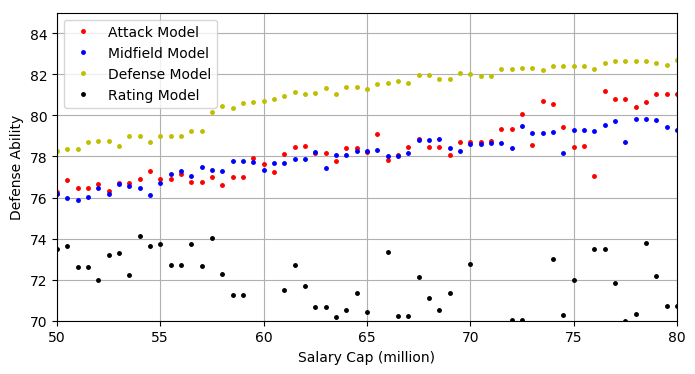

PyObject <matplotlib.legend.Legend object at 0x000000002F658A20>

In [35]:
using JuMP, DataFrames, PyPlot

Num = 11        # Total players in a team

figure(figsize=(8,4))
for maxSalary = 50:0.5:80
    (R1, Ra1, Rm1, Rd1, xopt1) = attackModel(λ, CBlimit, maxSalary, raw)
    (R2, Ra2, Rm2, Rd2, xopt2) = midfieldModel(λ, CBlimit, maxSalary, raw)
    (R3, Ra3, Rm3, Rd3, xopt3) = defendModel(λ, CBlimit, maxSalary, raw)
    (R4, Ra4, Rm4, Rd4, xopt4) = rateModel(CBlimit, maxSalary, raw)
    plot(maxSalary, Rd1,"r.", markersize=5)
    plot(maxSalary, Rd2,"b.", markersize=5)
    plot(maxSalary, Rd3,"y.", markersize=5)
    plot(maxSalary, Rd4,"k.", markersize=5)
end
axis([50,80,70,85])
grid("on")
ylabel("Defense Ability")
xlabel("Salary Cap (million)")
legend(["Attack Model", "Midfield Model", "Defense Model", "Rating Model"])

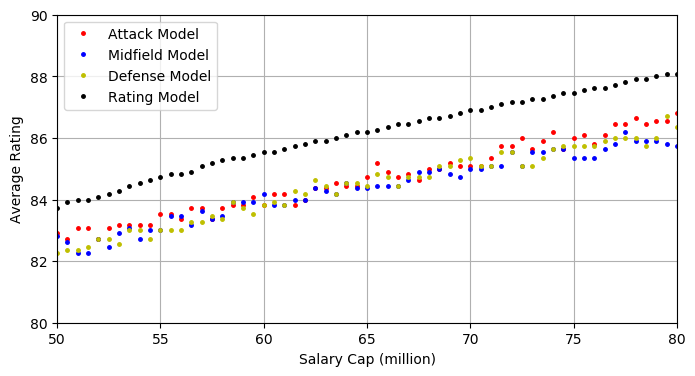

PyObject <matplotlib.legend.Legend object at 0x000000002F7C6C88>

In [36]:
using JuMP, DataFrames, PyPlot

Num = 11        # Total players in a team

figure(figsize=(8,4))
for maxSalary = 50:0.5:80
    (R1, Ra1, Rm1, Rd1, xopt1) = attackModel(λ, CBlimit, maxSalary, raw)
    (R2, Ra2, Rm2, Rd2, xopt2) = midfieldModel(λ, CBlimit, maxSalary, raw)
    (R3, Ra3, Rm3, Rd3, xopt3) = defendModel(λ, CBlimit, maxSalary, raw)
    (R4, Ra4, Rm4, Rd4, xopt4) = rateModel(CBlimit, maxSalary, raw)
    plot(maxSalary, R1,"r.", markersize=5)
    plot(maxSalary, R2,"b.", markersize=5)
    plot(maxSalary, R3,"y.", markersize=5)
    plot(maxSalary, R4,"k.", markersize=5)
end
axis([50,80,80,90])
grid("on")
ylabel("Average Rating")
xlabel("Salary Cap (million)")
legend(["Attack Model", "Midfield Model", "Defense Model", "Rating Model"])